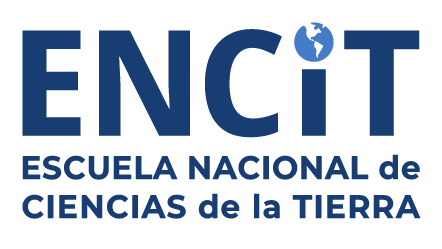
---
<a name='title'></a>
# **<font color="Navy"> Cambio Climático </font>**
## **<font color="RoyalBlue">Práctica con 1 modelo climático simple </font>**
### **<font color="DodgerBlue"> Notebook 2: Ejercicios con FAIR </font>**
### Escuela Nacional de Ciencias de la Tierra
#### Semestre 2025-I


---

## **<font color="ForestGreen"> Esqueleto del notebook </font>**

- Simulación control: descripción y diseño del experimento control o estándar. 
- Ejercicios:
    1. Sin aerosoles.
    2. Inyección de erupción volcánica
    3. Más variabilidad solar. 

2 ejercicios

In [2]:
pip install fair

Note: you may need to restart the kernel to use updated packages.


In [3]:
from fair import FAIR

In [82]:
# importamos otros paquetes
import numpy as np
import pandas as pd
import copy
import xarray as xr
import matplotlib.pyplot as plt

In [83]:
def lineplot_setup(xmin, xmax, xlab, ylab, ymin=None, ymax=None, title=None, legend=False):
    """
    Configura el entorno gráfico para un diagrama de líneas.

    Este método permite establecer los límites de los ejes, las etiquetas, 
    el título y, opcionalmente, activar la leyenda para un gráfico de líneas.

    Parámetros:
    -----------
    xmin : float
        Valor mínimo del eje X.
    xmax : float
        Valor máximo del eje X.
    xlab : str
        Etiqueta para el eje X.
    ylab : str
        Etiqueta para el eje Y.
    ymin : float, opcional
        Valor mínimo del eje Y (por defecto es None, no se ajusta).
    ymax : float, opcional
        Valor máximo del eje Y (por defecto es None, no se ajusta).
    title : str, opcional
        Título del gráfico (por defecto es None, no se asigna título).
    legend : bool, opcional
        Activa la leyenda del gráfico si se establece en True (por defecto es False).

    Retorna:
    --------
    None
        La función no retorna nada, sólo ajusta el gráfico.

    Ejemplo de uso:
    ---------------
    lineplot_setup(0, 10, 'Tiempo (s)', 'Velocidad (m/s)', 0, 100, title='Gráfico de Velocidad', legend=True)
    """
    
    # Especificar límites mínimos y máximos del gráfico
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    # Cuadrícula interna del gráfico
    plt.grid(linestyle='--', alpha=0.66)
    plt.minorticks_on()

    # Ajustar el tamaño de las etiquetas de ambos ejes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlab, fontsize=14)
    plt.ylabel(ylab, fontsize=14)
    plt.title(title, fontsize=15)

    # Mostrar la leyenda si está activada
    if legend:
        plt.legend(fancybox=True, shadow=True, fontsize=12.5)

En este notebook ya no explicaremos cada paso, sólo daremos las instrucciones necesarias para correr el modelo las veces que sean necesarias. 

Recuerden que el orden de las siguientes instrucciones es de lo más importante. 

## **<font color="ForestGreen"> Paso 1: Iniciar la clase </font>**

In [84]:
# Esta es la simulacion control
f = FAIR()

## **<font color="ForestGreen"> Paso 2 Tiempo de simulacion </font>**

En este caso los escenarios están definidos de 1750 a 2100

In [85]:
f.define_time(1750, 2100, 1)

## **<font color="ForestGreen"> Paso 3: definir los escenarios </font>**

Aquí empiezan a resaltar las diferencias con el notebook anterior. Específicamente, vamos a utilizar sólo el escenario pre-establecido "ssp370".

Tomaremos los SSPs que se utilizaron en el proyecto CMIP, por lo que tenemos que utilizar los mismos nombres. 


In [86]:
# Definir lista de escenarios
scenarios = [ 'ssp370']
# Meterlos a la clase de Fair
f.define_scenarios(scenarios)

## **<font color="ForestGreen"> Paso 4 y 5: definir las configuraciones y especies </font>**

Por simplicidad, vamos a sólo utilizar un modelo aquí. El modelo británico HadGEM https://www.metoffice.gov.uk/research/approach/modelling-systems/unified-model/climate-models/hadgem3. 
Las propiedades de las especies las obtenemos directamente de FaIR.

Fíjense bien que aquí establecemos la variable para el nombre del modelo, `model_name`.

In [87]:
from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

In [88]:
species, properties = read_properties()
f.define_species(species, properties)

In [89]:
# Cargamos datos existentes ya en el paquete, para eso tenemos que saber donde esta el paquete fair en nuestro OS
df = pd.read_csv("4xCO2_cummins_ebm3.csv")
models = ['HadGEM3-GC31-MM']
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
# definir configuraciones 2 veces
f.define_configs(configs)

In [90]:
model_name=configs[0]

## **<font color="ForestGreen"> Paso 6: Generar los datos de input y output </font>**


In [91]:
f.allocate()
# rellenando configuraciones de especies
f.fill_species_configs()
# rellenando escenarios
f.fill_from_rcmip()

## **<font color="ForestGreen"> Paso 7: rellenando los datos </font>**

In [92]:
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [93]:
for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)

## <font color="ForestGreen">Paso 8. Correr FaIR  </font>

In [94]:
f.run()

Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

## <font color="OrangeRed"> Análisis de la simulación CTRL </font>

Primero vamos a analizar esta simulación un poco más, siguiendo la metodología del notebook anterior. 

Entre las variables que nos faltan por entender bien están: `f.emissions`, `f.concentration`, `f.forcing_sum` o `f.forcing`.

Vamos a empezar a ver las emisiones de este escenario.

In [95]:
f.forcing

<xarray.DataArray (timebounds: 351, scenario: 1, config: 1, specie: 64)> Size: 180kB
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],


       [[[            nan,             nan,  6.36268881e-04, ...,
           2.76959910e-04, -8.54586068e-05,             nan]]],


       [[[            nan,             nan,  1.16182228e-03, ...,
           5.20756805e-04, -1.72489406e-04,             nan]]],


       ...,


       [[[            nan,             nan,  6.87308618e+00, ...,
           9.26380881e-02, -2.69182767e-01,             nan]]],


       [[[            nan,             nan,  6.93681034e+00, ...,
           9.30404403e-02, -2.69940605e-01,             nan]]],


       [[[            nan,             nan,  7.00057118e+00, ...,
           9.34401197e-02, -2.70701062e-01,             nan]]]])
Coordinates:
  * timebounds  (timebounds) float64 3kB 1.75e+03 1.751e+03 ... 2.1e+03
  * scenario    (scenario) <U6 24B 'ssp370'
  * config      (config) <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
  * specie      (specie) <U43 11kB 'CO2 FFI' ... 'Equivalent effective strato...

In [96]:
f.forcing.specie

<xarray.DataArray 'specie' (specie: 64)> Size: 11kB
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1202', 'Halon-1211',
       'Halon-1301', 'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10',
       'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125',
       'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'NOx aviation',
       'Solar', 'Volcanic', 'Aerosol-radiation interactions',
       'Aerosol-cloud interactions', 'Ozone', 'Contrails',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine'], dtype='<U43')
Coordinates:
  * specie   (specie) <U43 11kB 'CO2 FFI' ... 'Equivalent effective stratosph...

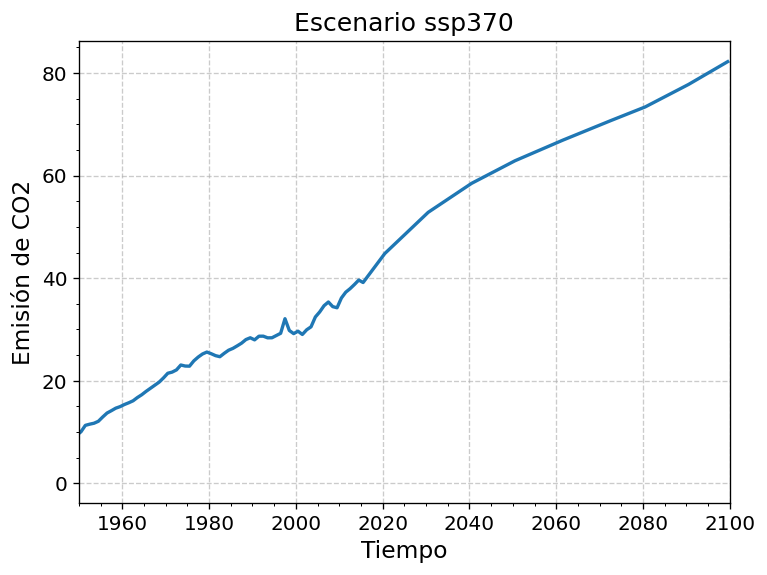

In [97]:
plt.figure(figsize=(7,5),dpi=120)
plt.plot(f.timepoints, f.emissions.loc[dict(specie='CO2')].squeeze(), linewidth=2)
lineplot_setup(1950,2100,'Tiempo','Emisión de CO2',legend=False,title='Escenario ssp370')

Todas las emisiones vienen acompañadas de una concentración. En este caso, podemos ver cómo es que este escenario supone que van a ser las concentraciones de CO2. ¿En qué año se supera la duplicación de las concentraciones preindustriales (280 ppm)?

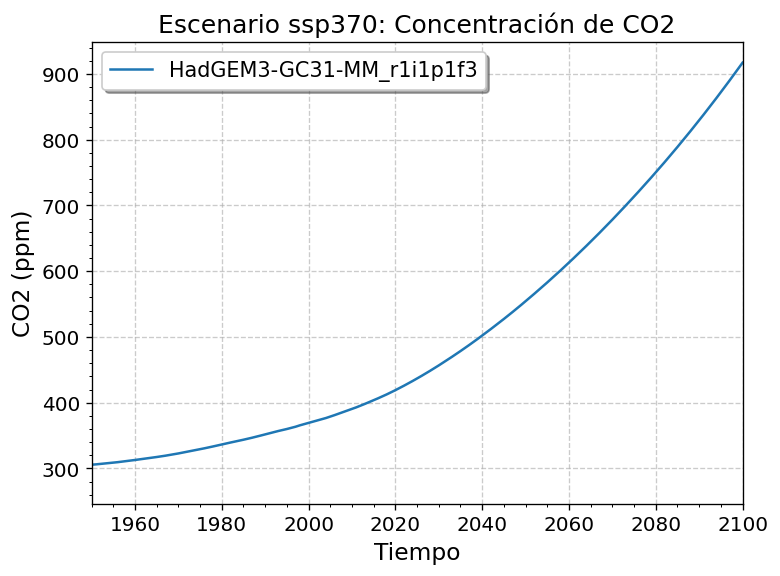

In [98]:
# Vamos ahora a analizar las concentraciones y el forzamiento, o sea por que obtuvimos estos resultados
plt.figure(figsize=(7,5),dpi=120)
plt.plot(f.timebounds, f.concentration.loc[dict( specie='CO2')].squeeze(), label=f.configs)
lineplot_setup(1950,2100,'Tiempo','CO2 (ppm)',legend=True,title='Escenario ssp370: Concentración de CO2')

Podemos ver otra especie, cambiando la palabra clave en el diccionario que selecciona al objeto de concentración. 

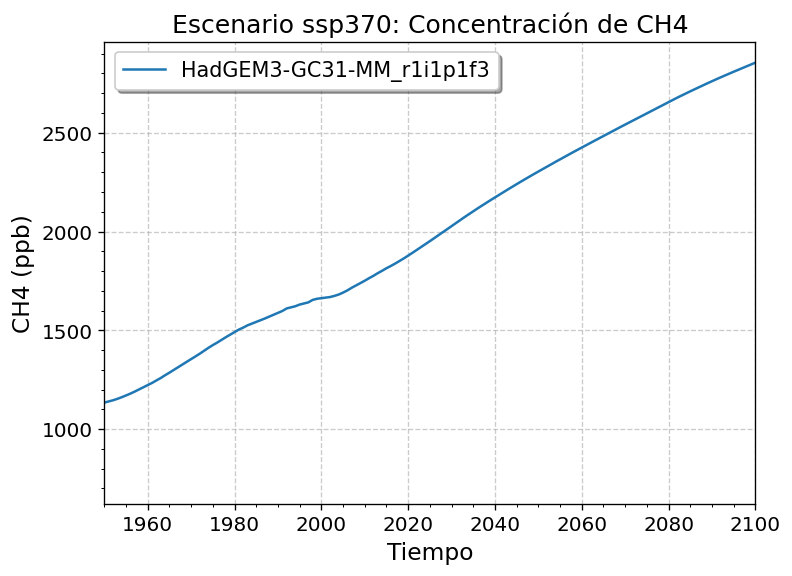

In [99]:
# Vamos ahora a analizar las concentraciones y el forzamiento, o sea por que obtuvimos estos resultados
plt.figure(figsize=(7,5),dpi=120)
plt.plot(f.timebounds, f.concentration.loc[dict( specie='CH4')].squeeze(), label=f.configs)
lineplot_setup(1950,2100,'Tiempo','CH4 (ppb)',legend=True,title='Escenario ssp370: Concentración de CH4')

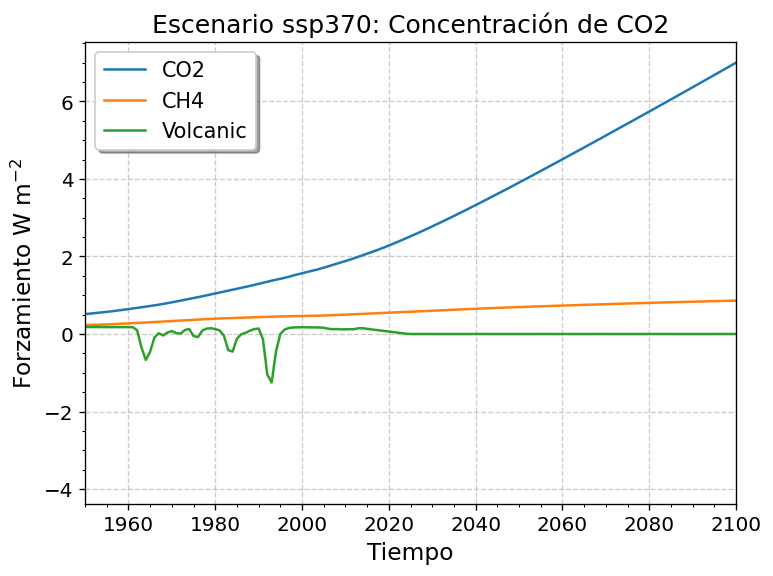

In [100]:
# Vamos ahora a analizar las concentraciones y el forzamiento, o sea por que obtuvimos estos resultados
plt.figure(figsize=(7,5),dpi=120)
plt.plot(f.timebounds, f.forcing.loc[dict( specie=['CO2','CH4','Volcanic'])].squeeze(), label=['CO2','CH4','Volcanic'])
lineplot_setup(1950,2100,'Tiempo','Forzamiento W m$^{-2}$',legend=True,title='Escenario ssp370: Concentración de CO2')

---
<a name='ej-1'></a>
### **<font color="DodgerBlue">Ejercicio 1 - Primeras graficas con FaIR </font>**

<font color="DarkBlue"> 1. Grafique la serie de tiempo de la temperatura resultado de la simulación anterior.     
    
---

## **<font color="ForestGreen"> Modificando los forzamientos en FaIR </font>**
 
Este ejercicio utiliza los escenarios de CMIP, en particular el ssp370, en una versión más directa de la simulación con FaIR. Con respecto a la simulación del notebook anterior sólo vamos a modificar 3 cosas. 

1. La emisión de azufre será 0. 
2. Inserción de una erupción volcánica. 
3. Variabilidad solar modificada. 

Al final del ejercicio podremos contestar las siguientes preguntas.

1. ¿Qué efecto tiene el azufre en el clima? ¿Cuál es la razón de este impacto en el forzamiento y la temperatura?

2. ¿Qué tanto afecta una erupción volcánica fuerte al forzamiento radiativo? ¿Y qué tal a la temperatura promedio después de 3 años?

3. ¿Qué tan relevante es el forzamiento solar comparado al forzamiento por aerosoles o por GEIs? ¿Qué pasa si triplicamos la magnitud del forzamiento solar en un escenario? ¿Qué efectos espera en la temperatura? 
 
 
  ## **<font color="ForestGreen"> Ejercicio 1: forzamiento por aerosoles </font>**

 ### **<font color="ForestGreen"> Configuración de la simulación </font>**

In [101]:
# Esta será la simulacion sin azufre.
f2 = FAIR()

In [102]:
f2.define_time(1750, 2100, 1)
f2.define_scenarios(scenarios)

In [103]:
f2.define_species(species, properties)
f2.define_configs(configs)

In [104]:
f2.allocate()
f2.fill_species_configs()
f2.fill_from_rcmip()


<div class="alert alert-block alert-info">
<b>Nota:</b> 
Una vez que ya rellenamos todos los arrays con las emisiones y concentraciones por default de CMIP6, para el escenario ssp370, podemos modificar una cosa. 

Aquí es donde volvemos 0 las emisiones de azufre. Noten que sólo lo hacemos para `f2`. 
</div>



In [105]:
print(f.emissions.loc[dict(specie='Sulfur')])
# modificamos las emisiones de f2
f2.emissions.loc[dict(specie=['Sulfur'])]=0.0
print(f2.emissions.loc[dict(specie='Sulfur')])

<xarray.DataArray (timepoints: 350, scenario: 1, config: 1)> Size: 3kB
array([[[  2.44004843]],

       [[  2.40837914]],

       [[  2.39711604]],

       [[  2.41069336]],

       [[  2.46206525]],

       [[  2.44235514]],

       [[  2.41918432]],

       [[  2.50746469]],

       [[  2.47974383]],

       [[  2.47352803]],

...

       [[ 83.61622914]],

       [[ 83.06934404]],

       [[ 82.52245895]],

       [[ 81.97557385]],

       [[ 81.42868875]],

       [[ 80.88180365]],

       [[ 80.33491855]],

       [[ 79.78803346]],

       [[ 79.24114836]],

       [[ 78.69426326]]])
Coordinates:
  * timepoints  (timepoints) float64 3kB 1.75e+03 1.752e+03 ... 2.1e+03
  * scenario    (scenario) <U6 24B 'ssp370'
  * config      (config) <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
    specie      <U43 172B 'Sulfur'
<xarray.DataArray (timepoints: 350, scenario: 1, config: 1)> Size: 3kB
array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]

In [106]:
initialise(f2.concentration, f2.species_configs['baseline_concentration'])
initialise(f2.forcing, 0)
initialise(f2.temperature, 0)
initialise(f2.cumulative_emissions, 0)
initialise(f2.airborne_emissions, 0)

In [107]:
for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f2.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f2.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f2.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)

In [108]:
f2.run()

Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

## <font color="OrangeRed"> Análisis de la simulación sin aerosoles </font>

Ahora vamos a graficar nuestros resultados bonitos. Pero antes, hay que investigar que resultados tenemos. 
Primero tenemos que recordar el nombre de los modelos hemos utilizado y cómo se llaman. Esto ya lo hemos impreso a pantalla antes pero lo volvemos a hacer. 

Vemos que las emisiones por azufre empiezan a tener un impacto marcado a partir de 1900, donde la curva Control tiene un menor forzamiento que la que no tiene azufre. Veamos ahora qué pasó con la temperatura.

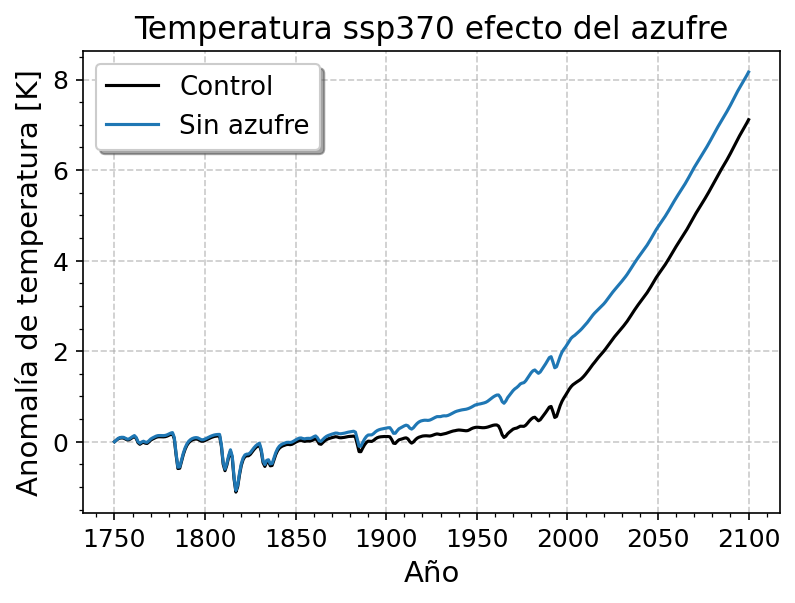

In [109]:
model_name='HadGEM3-GC31-MM_r1i1p1f3'
plt.figure(figsize=(6,4),dpi=150)
plt.plot(f.timebounds, f.temperature.loc[dict(config=model_name,layer=0)], label='Control',c='k');
plt.plot(f2.timebounds, f2.temperature.loc[dict(config=model_name,layer=0)], label='Sin azufre');
lineplot_setup(None,None,'Año','Anomalía de temperatura [K]',title='Temperatura ssp370 efecto del azufre',legend=True)


### **<font color="Orange">  Inspeccionando un poco más </font>**

El número de "botones" en FaIR es algo complicado porque quiere decir que no es trivial atribuir los resultados de temperatura a un sólo proceso. Pero si uno entiende un poco sobre los objetos en FaIR que tenemos a nuestra disposición podemos investigar un poco más sobre el modelo. Por ejemplo, existen 2 objetos asociados al forzamiento: 

1. forcing_sum: forzamiento total, producto de la suma de todos los forzamientos individuales. 
2. forcing: forzamiento por especie. 

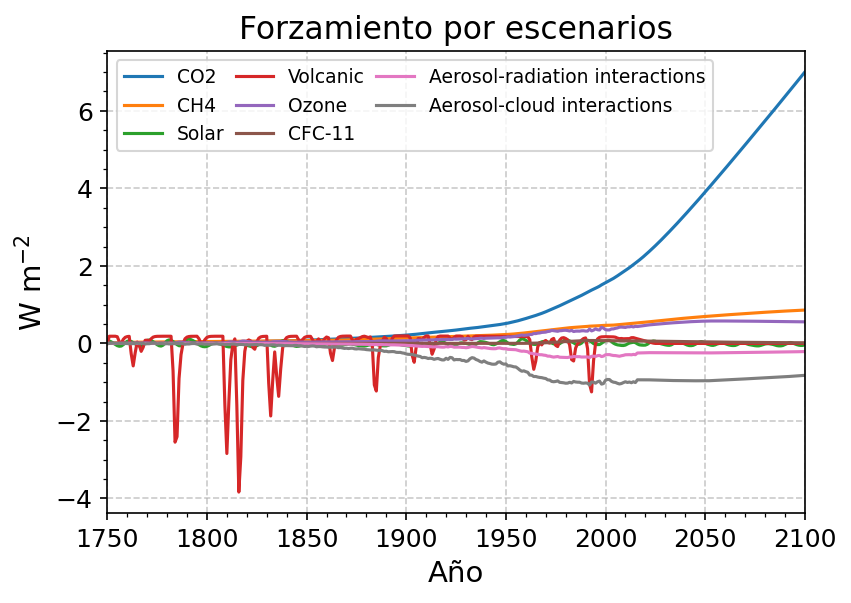

In [110]:
plt.figure(figsize=(6,4),dpi=150)
for specie in ['CO2','CH4','Solar','Volcanic','Ozone','CFC-11','Aerosol-radiation interactions','Aerosol-cloud interactions']:
    if f.forcing.loc[dict(config='HadGEM3-GC31-MM_r1i1p1f3',scenario='ssp370',specie=specie)].all().isnull():
        continue
    else:
        plt.plot(f.timebounds, f.forcing.loc[dict(config='HadGEM3-GC31-MM_r1i1p1f3',scenario='ssp370',specie=specie)], label=specie);
lineplot_setup(1750,2100,'Año','W m$^{-2}$',title='Forzamiento por escenarios',legend=False)
plt.legend(fontsize=9,ncol=3,columnspacing=0.6)

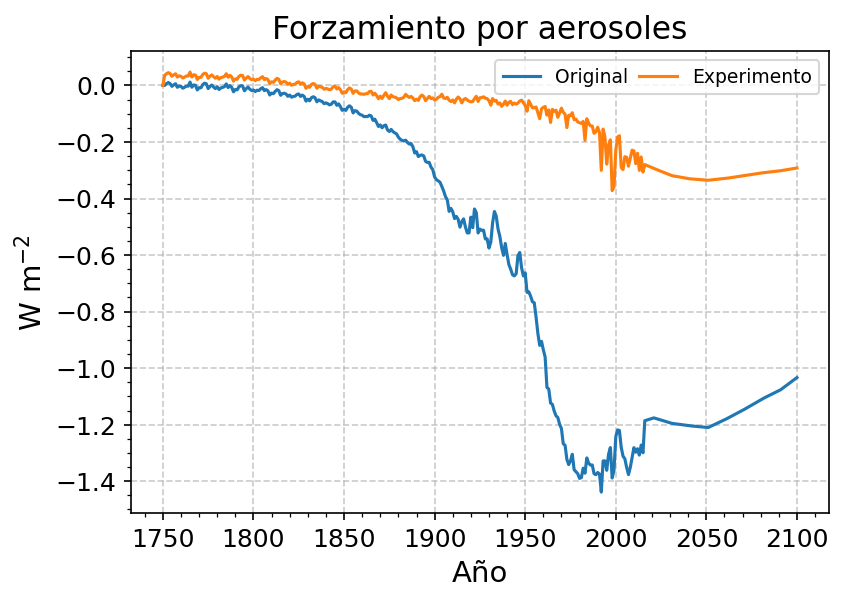

In [111]:
plt.figure(figsize=(6,4),dpi=150)
aerosol_forcing=['Aerosol-radiation interactions','Aerosol-cloud interactions']
orig_f=f.forcing.loc[dict(config='HadGEM3-GC31-MM_r1i1p1f3',scenario='ssp370',specie=aerosol_forcing)]
exp_f=f2.forcing.loc[dict(config='HadGEM3-GC31-MM_r1i1p1f3',scenario='ssp370',specie=aerosol_forcing)]

orig_f_sum=orig_f.sum('specie')
exp_f=exp_f.sum('specie')

plt.plot(f.timebounds, orig_f_sum, label='Original');
plt.plot(f.timebounds, exp_f, label='Experimento');
lineplot_setup(None,None,'Año','W m$^{-2}$',title='Forzamiento por aerosoles',legend=False)
plt.legend(fontsize=9,ncol=3,columnspacing=0.6)

Ahora tenemos información casi suficiente para responder la primer ronda de preguntas:
    
  ### 1. ¿Qué efecto tiene el azufre en el clima? ¿Cuál es la razón de este impacto en el forzamiento y la temperatura?
   
   **R**= Uno de los principales efectos de las emisiones de azufre son las emisiones de dióxido de azufre (SO$_2$), que es un subproducto de la quema de combustibles fósiles, especialmente carbón y petróleo. Cuando el SO$_2$ se emite a la atmósfera, puede reaccionar con otros compuestos y formar aerosoles de sulfato, que son partículas microscópicas suspendidas en el aire. Estas emisiones tienden a formar aerosoles que terminan teniendo un rol de enfriamiento al reflejar la radiación solar de vuelta al espacio.  Por otro lado, los aerosoles de sulfato también pueden afectar a las nubes al actuar como núcleos de condensación, lo que puede influir en la cantidad y el tipo de nubes que se forman. 
   
  Con respecto al ejercicio, vemos que la emisión de azufre enfría el clima, porque la simulación control tiene menor forzamiento positivo que la simulación sin azufre podemos inferir que entonces el azufre tenía un forzamiento negativo. Por esta razón la anomalía de temperatura finales de siglo es mayor cuando removemos el azufre, ya que estamos quitando un forzamiento que actúa en contra del efecto de los gases de efecto invernadero. 
   La razón de fondo es que las emisiones de SO2 tienen un efecto profundamente negativo en el forzamiento radiativo ya que reflejan directamente la radiación solar, impidiendo que llegue a la superficie, pero también porque fungen como núcleos de condensación de nube, lo que también aumenta el albedo planetario y enfría la superficie. FaIR nos ha permitido constatar eso. 

  ## **<font color="ForestGreen"> Ejercicio 2: Erupción volcánica </font>**
  
Ahora cambiaremos ligeramente de tema al tratar el tema de los **forzamientos naturales** como lo pueden ser los forzamientos volcánicos.
  
  Históricamente, sabemos que las erupciones volcánicas enfrían el clima. Esto se debe a que durante una erupción volcánica, se emiten gases como dióxido de azufre (SO$_2$), dióxido de carbono (CO$_2$), vapor de agua y otros compuestos volátiles. Además, se liberan grandes cantidades de ceniza y partículas finas en la atmósfera.
  
 El SO$_2$ liberado durante una erupción volcánica puede reaccionar con el oxígeno y el agua en la atmósfera para formar aerosoles de sulfato. Estos aerosoles actúan como pequeñas partículas reflectantes que dispersan la luz solar, lo que resulta en un enfriamiento de la atmósfera al bloquear parte de la radiación solar entrante.
 
 ### Preguntas del ejercicio

1. ¿Cuál es el impacto de una erupción volcánica extrema sobre el clima?
2. ¿Qué tanto afecta una erupción volcánica fuerte al forzamiento radiativo? ¿Y qué tal a la temperatura promedio después de 3 años?
3. ¿Cuánto tiempo dura el impacto climático de una erupción volcánica?
  
 ### Solución
  
Para responder a la pregunta, el planteamiento será el siguiente:

1. Representar una emisión volcánica a través de una modificación del forzamiento "Volcanic". 
2. Insertar una "erupción en el año 2024" de tamaño mayor a cualquier otra erupción vista.

 ### Simulación

  En la siguiente celda, hacemos los pasos 1 al 5.

In [112]:
# paso 1
f3 = FAIR()
# paso 2
f3.define_time(1750, 2100, 1)
# paso 3
f3.define_scenarios(scenarios)
# paso 4 y 5
f3.define_species(species, properties)
f3.define_configs(configs)

Los pasos 6 y 7 también son como en ejercicios anteriores, entonces podemos sólo escribir:

In [113]:
# paso 6 
f3.allocate()
# paso 7
f3.fill_species_configs()
f3.fill_from_rcmip()


Ahora aquí es donde queremos modificar al forzamiento, específicamente al forzamiento correspondiente a "Volcanic". 
Para recordarnos las especies que están incluidas en forzamiento puede ser útil imprimir este objeto. 

In [114]:
f3.forcing.specie

<xarray.DataArray 'specie' (specie: 64)> Size: 11kB
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1202', 'Halon-1211',
       'Halon-1301', 'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10',
       'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125',
       'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'NOx aviation',
       'Solar', 'Volcanic', 'Aerosol-radiation interactions',
       'Aerosol-cloud interactions', 'Ozone', 'Contrails',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine'], dtype='<U43')
Coordinates:
  * specie   (specie) <U43 11kB 'CO2 FFI' ... 'Equivalent effective stratosph...

Vemos que efectivamente hay un forzamiento que se llama "Volcanic", vamos a modificarlo. 

En nuestro caso vamos a poner una erupción volcánica en el año 1982, el año en el que nació el profesor. Antes de modificar el forzamiento vamos a hacer una grafiquita rápida utilizando el experimento _Control_ para ver de qué tamaño es la unidad del forzamiento volcánico y cómo se ve su evolución en el tiempo.


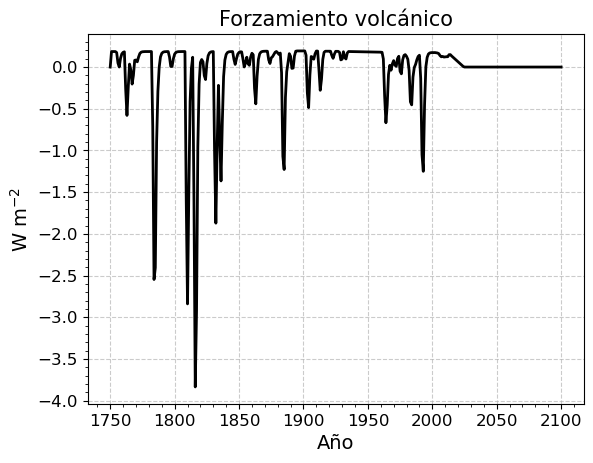

In [115]:
plt.plot(f.timebounds,f.forcing.loc[dict(specie='Volcanic',config=model_name)].squeeze(),label='Control',linestyle='-',c='k',linewidth=2)
lineplot_setup(None,None,'Año','W m$^{-2}$',title='Forzamiento volcánico',legend=False)

La gráfica muestra que el forzamiento volcánico llega a tener valores de casi -4.0 W m$^{-2}$ por lo que una erupción fuerte podría ser de este tamaño o quizás mayor. 

De esta manera, vamos a generar una erupción como nunca antes vista con un forzamiento de -5.0 W m$^{-2}$.

In [116]:
# -4 parece ser suficientemente fuerte.
f3.forcing.loc[dict(specie='Volcanic',timebounds=2024)]=-5

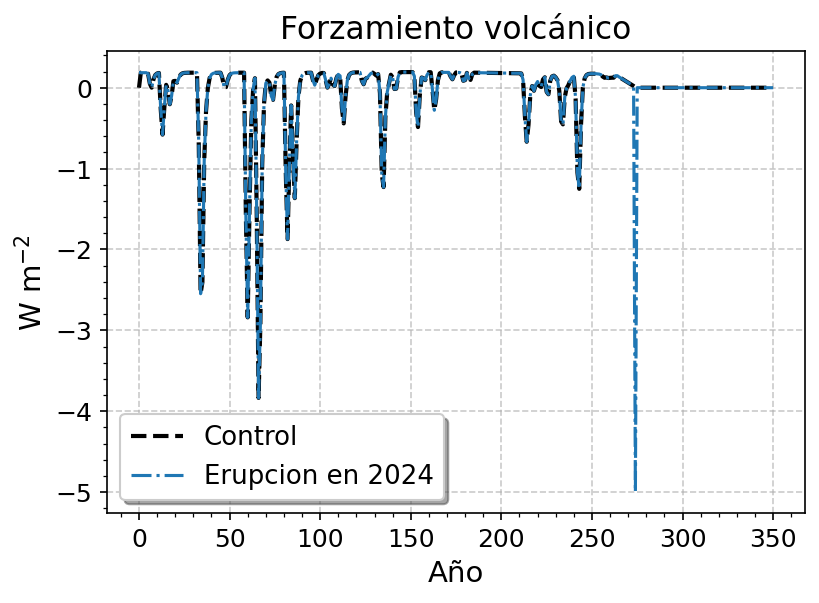

In [117]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(f.forcing.loc[dict(specie='Volcanic',config=model_name)].squeeze(),label='Control',linestyle='--',c='k',linewidth=2)
plt.plot(f3.forcing.loc[dict(specie='Volcanic',config=model_name)].squeeze(),label='Erupcion en 2024',linestyle='-.')
lineplot_setup(None,None,'Año','W m$^{-2}$',title='Forzamiento volcánico',legend=True)

Ahora regresamos a configurar la simulación de `f3`. Las siguientes dos celdas representan el **paso 8**.
Noten que no hemos hecho nada diferente comparado con la simulación original salvo en el paso anterior. 

In [118]:
# paso 8a
for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f3.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f3.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f3.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)

In [119]:
# paso 8b
initialise(f3.concentration, f3.species_configs['baseline_concentration'])
initialise(f3.forcing, 0)
initialise(f3.temperature, 0)
initialise(f3.cumulative_emissions, 0)
initialise(f3.airborne_emissions, 0)

Finalmente el **paso 9**. 

In [120]:
f3.run()

Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

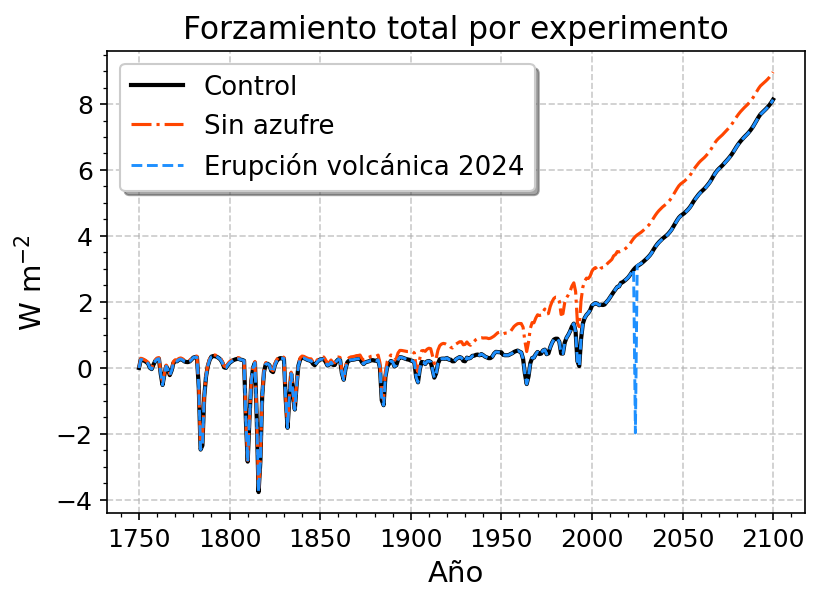

In [121]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(f.timebounds, f.forcing_sum.loc[dict(config=model_name)], label='Control',linestyle='-',c='k',linewidth=2);
plt.plot(f2.timebounds, f2.forcing_sum.loc[dict(config=model_name)], label='Sin azufre',linestyle='-.',c='orangered');
plt.plot(f3.timebounds, f3.forcing_sum.loc[dict(config=model_name)], label='Erupción volcánica 2024',linestyle='--',linewidth=1.4,c='dodgerblue');
lineplot_setup(None,None,'Año','W m$^{-2}$',title='Forzamiento total por experimento',legend=True)

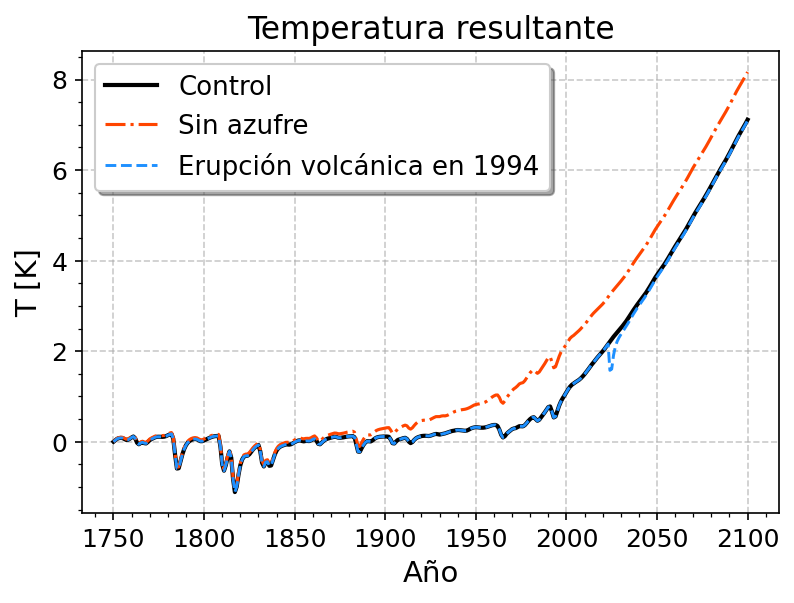

In [122]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(f.timebounds, f.temperature.loc[dict(config=model_name,layer=0)], label='Control',linestyle='-',c='k',linewidth=2);
plt.plot(f2.timebounds, f2.temperature.loc[dict(config=model_name,layer=0)], label='Sin azufre',linestyle='-.',c='orangered');
plt.plot(f3.timebounds, f3.temperature.loc[dict(config=model_name,layer=0)], label='Erupción volcánica en 1994',linestyle='--',linewidth=1.4,c='dodgerblue');
lineplot_setup(None,None,'Año','T [K]',title='Temperatura resultante',legend=True)

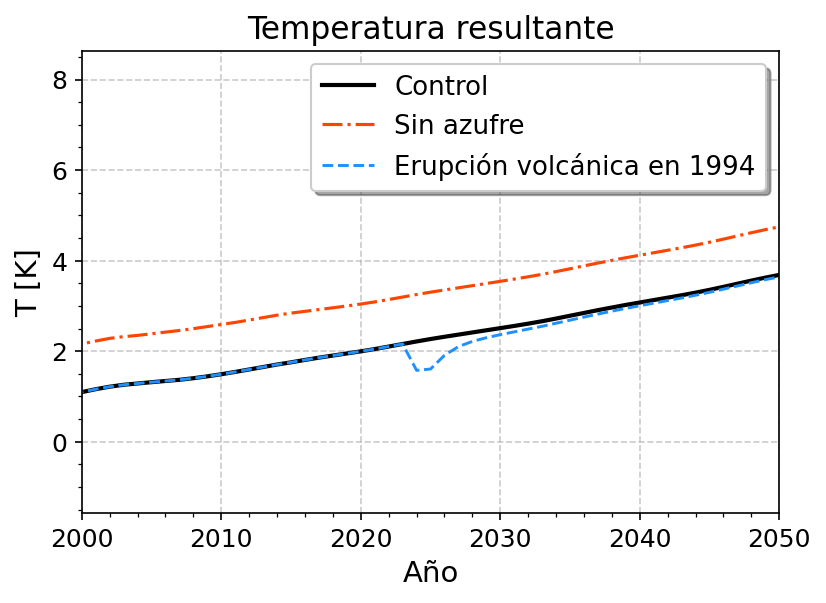

In [123]:
# zooom a la grafica de T
plt.figure(figsize=(6,4),dpi=150)
plt.plot(f.timebounds, f.temperature.loc[dict(config=model_name,layer=0)], label='Control',linestyle='-',c='k',linewidth=2);
plt.plot(f2.timebounds, f2.temperature.loc[dict(config=model_name,layer=0)], label='Sin azufre',linestyle='-.',c='orangered');
plt.plot(f3.timebounds, f3.temperature.loc[dict(config=model_name,layer=0)], label='Erupción volcánica en 1994',linestyle='--',linewidth=1.4,c='dodgerblue');
lineplot_setup(2000,2050,'Año','T [K]',title='Temperatura resultante',legend=True)

Habiendo terminado esta simulación y sus gráficas podemos contestar la pregunta del ejercicio. 

1. ¿Cuál es el impacto de una erupción volcánica extrema sobre el clima?

El experimento realizado demuestra que la erupción volcánica insertada tiene un efecto de **enfriar** el clima, ya que vemos una disminución en la temperatura en este experimento en 2024 comparado al experimento control. Sin embargo, en la gráfica de temperatura vemos que dicha disminución solo dura unos cuantos años. Es un forzamiento puntual y de corta duración pero que puede causar impactos regionales profundos que luego afectan a su vez dinámicas regionales y teleconexiones. 

- Driscoll, Simon, et al. "Coupled Model Intercomparison Project 5 (CMIP5) simulations of climate following volcanic eruptions." Journal of Geophysical Research: Atmospheres 117.D17 (2012). https://doi.org/10.1029/2012JD017607

2. ¿Qué tanto afecta una erupción volcánica fuerte al forzamiento radiativo? 


 Pusimos una erupción tan fuerte como cualquier otra en el registro histórico en 2024. Esto afectó fuertemente el forzamiento radiativo, volviéndolo negativo para ese año. Sin embargo, para el año 2026, ya no había vestigio alguno de la erupción en la serie de tiempo del forzamiento, ya que las curvas de _Control_ y con erupción son exactamente iguales. Esto quiere decir que una erupción volcánica provoca un forzamiento negativo fuerte pero de corta duración.

3. ¿Cuánto tiempo dura el impacto climático de una erupción volcánica? ¿Cómo es el impacto de este experimento sobre la temperatura promedio después de 3 años?

En el caso de la temperatura, sí podemos observar una ligera disminución de la temperatura, de aproximadamente 0.25 grados Celsius con respecto a la curva _Control_ para el año 2024, pero esta diferencia desaparece también rápidamente, para el año 2030, esta diferencia es muy pequeña. Para 2024, prácticamente ya no hay diferencias entre ambas curvas. Esto se debe a que el forzamiento por volcanes es puntual, y no tiene un impacto de gran duración en escalas climáticas. Físicamente, los aerosoles, a diferencia del CO2, no duran tanto tiempo en la atmósfera. En nuestro modelo, nuestra modificación del forzamiento fue puntual por lo que este forzamiento es rápidamente asimilado por el sistema climático de FaIR, en este caso el océano.

## **<font color="ForestGreen"> Ejercicio 3: el forzamiento solar </font>**

Este ejercicio final buscará entender el rol del forzamiento solar sobre el clima. Las preguntas guía de investigación son:

1. ¿Qué tan relevante es el forzamiento solar comparado al forzamiento por aerosoles o por GEIs? ¿Qué pasa si triplicamos la magnitud del forzamiento solar en un escenario? ¿Qué efectos espera en la temperatura?

Empezamos una nueva simulación desde 0.

In [124]:
# pasos 1 al 7
f4 = FAIR()
f4.define_time(1750, 2100, 1)
f4.define_scenarios(scenarios)
f4.define_species(species, properties)
f4.define_configs(configs)
f4.allocate()
f4.fill_species_configs()
f4.fill_from_rcmip()

Ahora sí, vamos a ver cómo es el forzamiento solar y a modificarlo. 
También vamos a sacar su desviación estándar para ver cuánto varía. Recuerden que el forzamiento siempre está en $W m^{-2}$. 

In [125]:
f4.forcing.loc[dict(specie='Solar')]

<xarray.DataArray (timebounds: 351, scenario: 1, config: 1)> Size: 3kB
array([[[ 8.27945382e-02]],

       [[ 6.44482492e-02]],

       [[ 4.02361398e-02]],

       [[ 7.10829555e-03]],

       [[-2.81880301e-02]],

       [[-5.76341361e-02]],

       [[-7.36637381e-02]],

       [[-6.78837211e-02]],

       [[-3.26341971e-02]],

       [[ 1.82939157e-02]],

...

       [[-7.14803278e-03]],

       [[ 1.63177546e-02]],

       [[ 2.40958648e-02]],

       [[ 7.48170519e-03]],

       [[-1.24894811e-02]],

       [[-3.16586965e-02]],

       [[-4.55175305e-02]],

       [[-5.23229700e-02]],

       [[-5.08477744e-02]],

       [[-3.51423226e-02]]])
Coordinates:
  * timebounds  (timebounds) float64 3kB 1.75e+03 1.751e+03 ... 2.1e+03
  * scenario    (scenario) <U6 24B 'ssp370'
  * config      (config) <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
    specie      <U43 172B 'Solar'

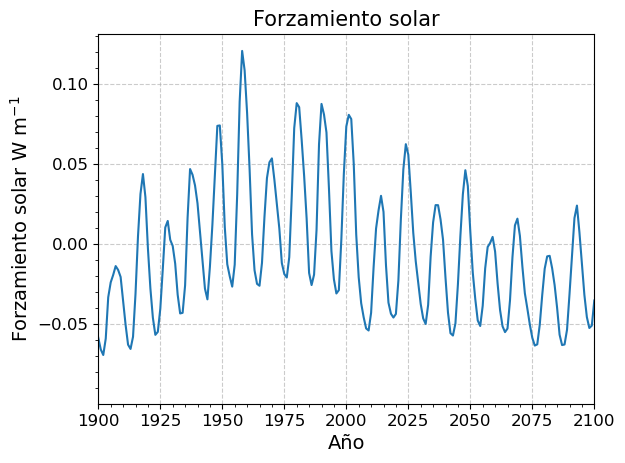

In [126]:
plt.plot(f4.timebounds,f4.forcing.loc[dict(specie='Solar')].squeeze())
lineplot_setup(1900,2100,'Año','Forzamiento solar W m$^{-1}$',title='Forzamiento solar',legend=False)


Ahora que hemos hecho una gráfica vemos que las estimaciones del IPCC sobre el forzamiento solar son relativamente pequeñas. Vamos a ver si podemos aumentar la variabilidad de este forzamiento. Para eso primero medimos la variabilidad con el estadístico de desviación estándar para este objeto.

In [127]:
std=f4.forcing.loc[dict(specie='Solar')].squeeze().std()
print(std)

<xarray.DataArray ()> Size: 8B
array(0.04450445)
Coordinates:
    scenario  <U6 24B 'ssp370'
    config    <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
    specie    <U43 172B 'Solar'


Ahora vamos a triplicar el forzmiento solar, para eso primero guardamos el original en otra variable y luego reemplazamos el valor del forzamiento solar por el original multiplicado por 3. 

In [128]:
orig_forcing = copy.deepcopy(f4.forcing.loc[dict(specie='Solar')])
f4.forcing.loc[dict(specie='Solar')]=orig_forcing*3

Para ver las diferencias, los graficamos. Luego, lo demás es igual a la simulación control.

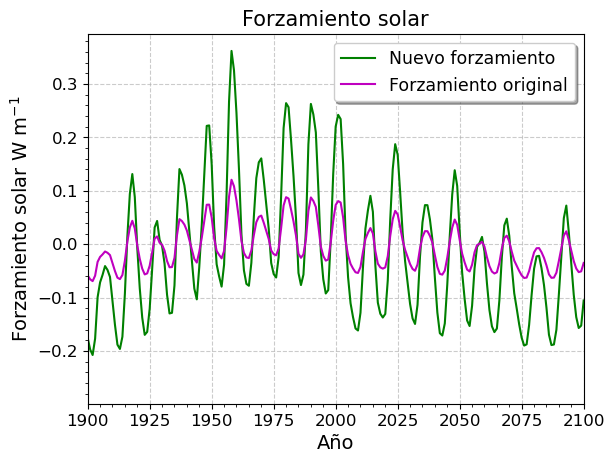

In [129]:
plt.plot(f4.timebounds,f4.forcing.loc[dict(specie='Solar')].squeeze(),c='green',label='Nuevo forzamiento')
plt.plot(f4.timebounds,orig_forcing.squeeze(),c='m',label='Forzamiento original')
lineplot_setup(1900,2100,'Año','Forzamiento solar W m$^{-1}$',title='Forzamiento solar',legend=True)

Una vez que hemos modificado `f4`, podemos terminar de configurar la simulación. 

In [130]:
# paso 8
for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f4.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f4.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f4.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)

In [131]:
# paso 9
initialise(f4.concentration, f4.species_configs['baseline_concentration'])
initialise(f4.forcing, 0)
initialise(f4.temperature, 0)
initialise(f4.cumulative_emissions, 0)
initialise(f4.airborne_emissions, 0)

In [132]:
f4.run()

Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

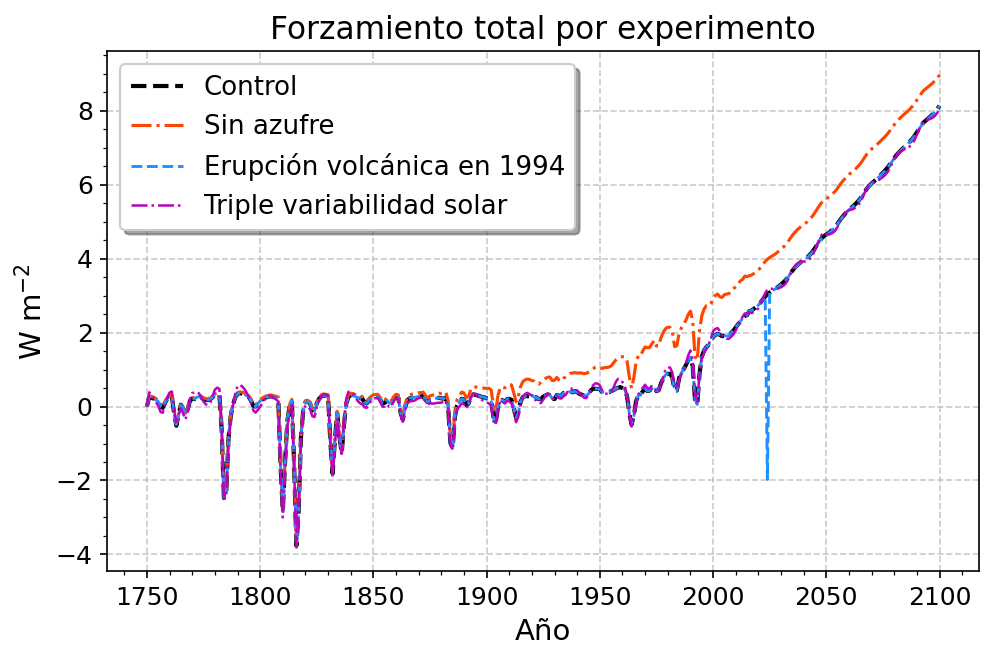

In [133]:
plt.figure(figsize=(7.5,4.5),dpi=150)
plt.plot(f.timebounds, f.forcing_sum.loc[dict(config=model_name)], label='Control',linestyle='--',c='k',linewidth=2);
plt.plot(f2.timebounds, f2.forcing_sum.loc[dict(config=model_name)], label='Sin azufre',linestyle='-.',c='orangered');
plt.plot(f3.timebounds, f3.forcing_sum.loc[dict(config=model_name)], label='Erupción volcánica en 1994',linestyle='--',linewidth=1.4,c='dodgerblue');
plt.plot(f4.timebounds, f4.forcing_sum.loc[dict(config=model_name)], label='Triple variabilidad solar',linestyle='-.',c='m',linewidth=1.2);
lineplot_setup(None,None,'Año','W m$^{-2}$',title='Forzamiento total por experimento',legend=True)

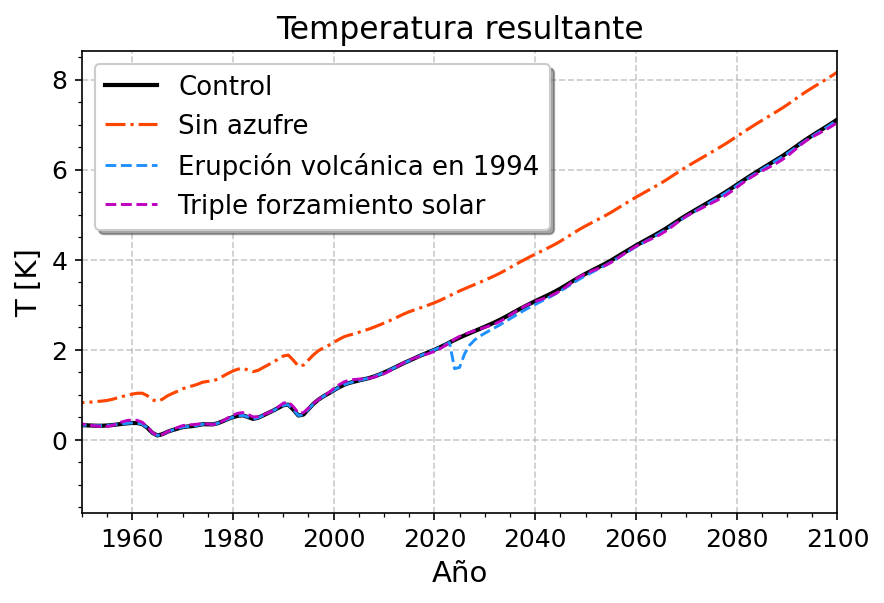

In [134]:
plt.figure(figsize=(6.5,4),dpi=150)
plt.plot(f.timebounds, f.temperature.loc[dict(config=model_name,layer=0)], label='Control',linestyle='-',c='k',linewidth=2);
plt.plot(f2.timebounds, f2.temperature.loc[dict(config=model_name,layer=0)], label='Sin azufre',linestyle='-.',c='orangered');
plt.plot(f3.timebounds, f3.temperature.loc[dict(config=model_name,layer=0)], label='Erupción volcánica en 1994',linestyle='--',linewidth=1.4,c='dodgerblue');
plt.plot(f4.timebounds, f4.temperature.loc[dict(config=model_name,layer=0)], label='Triple forzamiento solar',linestyle='--',linewidth=1.4,c='m');
lineplot_setup(1950,2100,'Año','T [K]',title='Temperatura resultante',legend=True)

Técnicamente sólo modificamos la variabilidad del forzamiento solar, no la tendencia ni tampoco el valor promedio. Entonces es posible que sólo hayamos modificado la variabilidad de la temperatura. Entonces, vamos a medir la variabiliad de la temperatura en el experimento del forzamiento solar y compararla con el Control. 

In [135]:
exp4_T_std=f4.temperature.loc[dict(config=model_name,layer=0)].std()
exp1_T_std=f.temperature.loc[dict(config=model_name,layer=0)].std()
print(exp1_T_std,exp4_T_std)

<xarray.DataArray ()> Size: 8B
array(1.96156839)
Coordinates:
    config   <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
    layer    int64 8B 0 <xarray.DataArray ()> Size: 8B
array(1.95783117)
Coordinates:
    config   <U24 96B 'HadGEM3-GC31-MM_r1i1p1f3'
    layer    int64 8B 0


Estos resultados muestran que si bien, hay un aumento numérico en la desviación estándar del experimento 4 con respecto al control, ha sido un cambio mínimo. 

A partir de estos resultados podemos responder las preguntas. 

1. ¿Qué tan relevante es el forzamiento solar comparado al forzamiento por aerosoles o por GEIs? ¿Qué pasa si triplicamos la magnitud del forzamiento solar en un escenario? ¿Qué efectos espera en la temperatura?

- En la primer gráfica, de este ejercicio, vimos que el forzamiento solar tiene una magnitud máxima de entre 0.2 y 0.3 W m${-1}$. Por otro lado, a lo largo de este notebook vimos que el forzamiento por aerosoles es de casi -1.4 W m$^{-2}$ a mediados de siglo y en los GEIs de hasta 7 W m$^{-2}$. Tan sólo el forzamiento por CO$_2$ supera 5 W m$^{-2}$ a finales de siglo.
- Después de triplicar la magnitud de la variabilidad solar, las gráficas de temperatura no mostraron cambios perceptibles en la simulación de la temperatura. Además, el cálculo de la desviación estándar de la temperatura mostró que triplicar la variabilidad solar apenas y modifica, en el orden de milésimas, la variabiliad de la temperatura. 
- A partir de estos puntos anteriores se puede concluir que la variabilidad solar es muy pequeña para influenciar la temperatura global **considerando** el tamaño del forzamiento antropogénico actual. Es decir, ante la magnitud del forzamiento por CO$_2$, el forzamiento solar aparece minúsculo. La variabilidad de la temperatura y su tendencia están dominadas por el forzamiento por GEIs y en menor grado por el forzamiento por aerosoles. 

---
<a name='ej-1'></a>
### **<font color="DodgerBlue">Ejercicio 2 - ¿Listos para la práctica? </font>**

<font color="DarkBlue"> 1. Realice una simulación con los escenarios _ssp460_ y _ssp585_ y dos modelos del CMIP.     
    
<font color="DarkBlue"> 2. Haga una gráfica e interprete sus resultados comparando los dos escenarios.    
    
---